# OHCL - Analytics

### Import Library

In [52]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [53]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [54]:
data_tmp = dataset.copy()
def bar9h(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
def bar14h(tick):
    tick=tick[(tick.index.hour == 14) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
data_tmp['Close_9h'] = data_tmp['Close']
data_tmp['Close_14h'] = data_tmp['Close']
day_data = data_tmp.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h': bar9h,
        'Close_14h': bar14h
    })
day_data.dropna(subset=['Close'], inplace=True)
day_data['Close_shift'] = day_data['Close'].shift(1)
day_data['Close_14h_shift'] = day_data['Close_14h'].shift(1)
day_data['Day_High_shift'] = day_data['High'].shift(1)
day_data['Day_Low_shift'] = day_data['Low'].shift(1)
day_data = day_data[['Close', 'High', 'Low', 'Close_shift', 'Close_14h_shift', 'Day_High_shift', 'Day_Low_shift']].rename(columns={'Close': 'Day_Close', 'High': 'Day_High', 'Low': 'Day_Low'})

In [55]:
day_data

,Day_Close,Day_High,Day_Low,Close_shift,Close_14h_shift,Day_High_shift,Day_Low_shift
Date,,,,,,,
2018-08-13,954.2,954.6,942.3,NaN,NaN,NaN,NaN
2018-08-14,959.3,961.8,952.1,954.2,949.5,954.6,942.3
2018-08-15,946.6,962.3,946.6,959.3,960.8,961.8,952.1
2018-08-16,947.0,947.3,935.5,946.6,957.7,962.3,946.6
2018-08-17,947.0,954.6,945.0,947.0,944.0,947.3,935.5
...,...,...,...,...,...,...,...
2024-07-29,1287.8,1294.7,1287.8,1285.0,1278.4,1285.0,1276.8
2024-07-30,1292.4,1292.4,1284.2,1287.8,1292.9,1294.7,1287.8
2024-07-31,1304.3,1304.3,1291.1,1292.4,1284.9,1292.4,1284.2


In [56]:
data = dataset.copy()
# data["ma_line"] = data["Close"].rolling(20).mean()
# data['above_ma'] = data.apply(lambda r: 1 if r['Close'] > r['ma_line'] else 0, axis=1)
# data['below_ma'] = data.apply(lambda r: 1 if r['Close'] < r['ma_line'] else 0, axis=1)
# data['total_above_ma'] = data['above_ma'].rolling(150).sum()
# data['total_below_ma'] = data['below_ma'].rolling(150).sum()
# data['trend_diff'] = data['total_above_ma'] - data['total_below_ma']
# data['ibs'] = data.apply(
#     lambda r: 0 if (r['High'] == r['Low']) else abs(r['Close'] - r['Low']) / (r['High'] - r['Low']), axis=1)
data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
data = pd.merge(data, day_data, left_on="time_d", right_index=True, how="left")

In [57]:
data = data[data.High != data.Low]
def get_percent(r):
    return (r['Close'] - r['Day_Low']) / (r['Day_High'] - r['Day_Low'])
data['percent'] = data.apply(lambda r: get_percent(r), axis=1)

In [58]:
data

,Open,High,Low,Close,Volume,time_d,Day_Close,Day_High,Day_Low,Close_shift,Close_14h_shift,Day_High_shift,Day_Low_shift,percent
Date,,,,,,,,,,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812,2018-08-13,954.2,954.6,942.3,NaN,NaN,NaN,NaN,0.065041
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323,2018-08-13,954.2,954.6,942.3,NaN,NaN,NaN,NaN,0.081301
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207,2018-08-13,954.2,954.6,942.3,NaN,NaN,NaN,NaN,0.065041
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196,2018-08-13,954.2,954.6,942.3,NaN,NaN,NaN,NaN,0.024390
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765,2018-08-13,954.2,954.6,942.3,NaN,NaN,NaN,NaN,0.113821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-02 14:05:00,1269.2,1273.4,1269.2,1270.8,22701,2024-08-02,1275.9,1277.5,1256.3,1275.0,1283.5,1306.2,1271.0,0.683962
2024-08-02 14:10:00,1270.9,1271.6,1268.9,1271.2,12412,2024-08-02,1275.9,1277.5,1256.3,1275.0,1283.5,1306.2,1271.0,0.702830
2024-08-02 14:15:00,1271.4,1276.8,1270.7,1274.7,14456,2024-08-02,1275.9,1277.5,1256.3,1275.0,1283.5,1306.2,1271.0,0.867925


In [59]:
data['last_close_rate'] = 1000*(data.Close - data.Close_shift) / data.Close_shift
data['last_highlow_rate'] = (data.Close - data.Close_14h_shift) /  (data.Day_High_shift - data.Day_Low_shift)

In [60]:
data.dropna(inplace=True)

In [61]:
data_test = data.copy()
data_test = data_test[data_test.index > '2024-01-01 00:00:00']
### Ignore this year data => tranh over fitting
data = data[data.index < '2024-01-01 00:00:00']

In [62]:
data['last_close_rate'].describe()

count    65850.000000
mean         0.401149
std         10.485020
min       -109.259259
25%         -2.810279
50%          0.682594
75%          4.731183
max         69.969040
Name: last_close_rate, dtype: float64

In [63]:
data['last_highlow_rate'].describe()

count    65850.000000
mean         0.024749
std          0.862492
min        -13.351351
25%         -0.385231
50%          0.067797
75%          0.479346
max          7.000000
Name: last_highlow_rate, dtype: float64

In [64]:
data['x_group'] = pd.qcut(data['last_close_rate'], 30)
data['y_group'] = pd.qcut(data['last_highlow_rate'], 20)

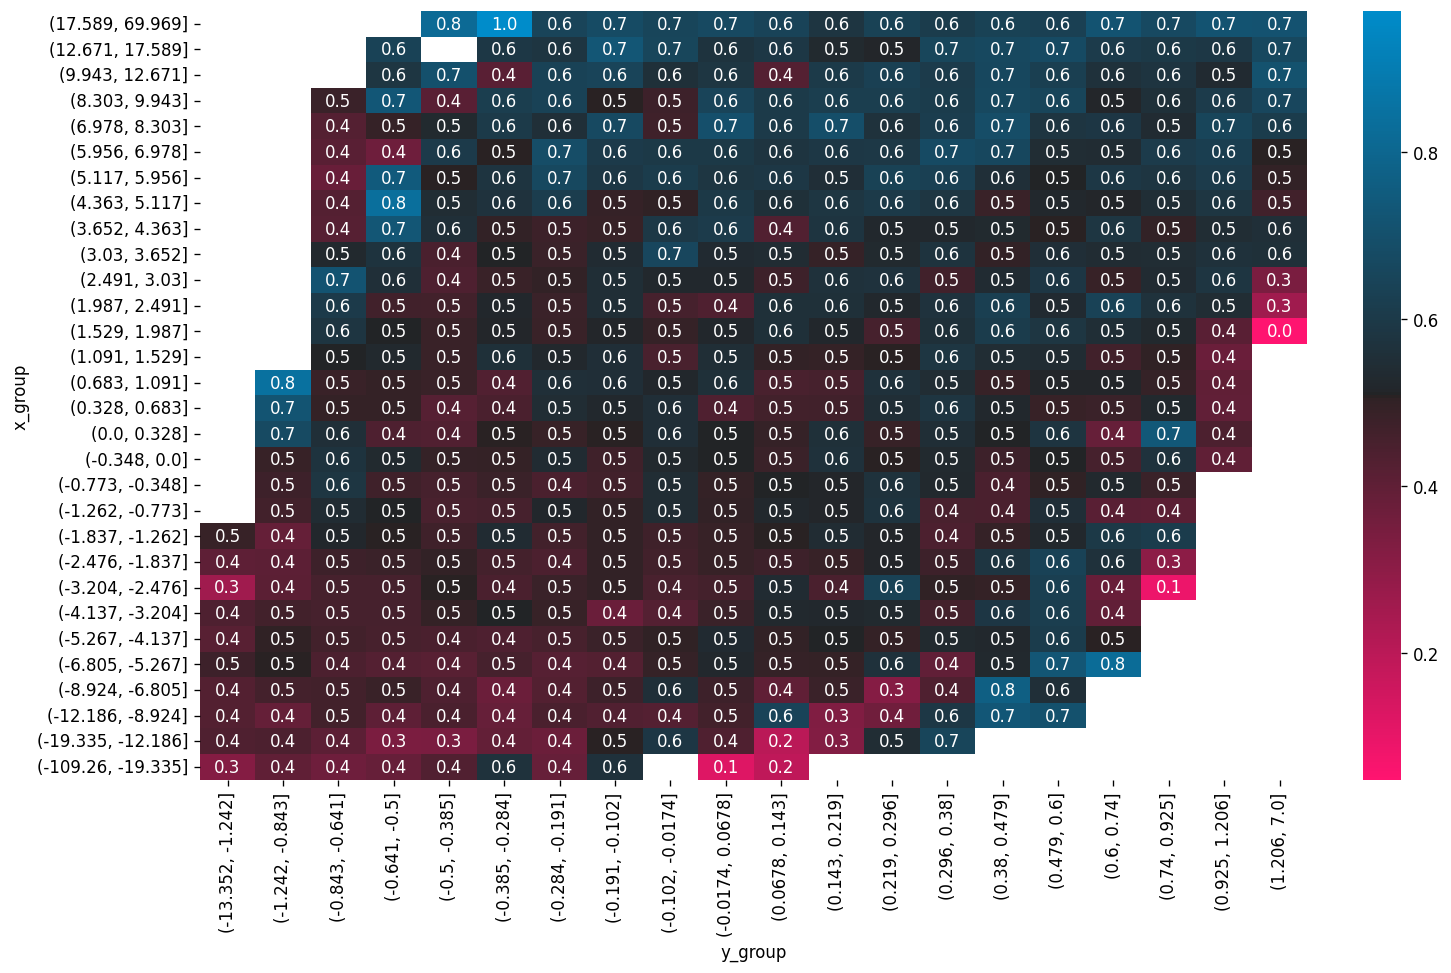

In [65]:
plt.rcParams['figure.figsize'] = [12, 8]
grpd = data.groupby(['x_group', 'y_group'])[['percent']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='x_group', columns='y_group', values='percent').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

In [66]:
day_data

,Day_Close,Day_High,Day_Low,Close_shift,Close_14h_shift,Day_High_shift,Day_Low_shift
Date,,,,,,,
2018-08-13,954.2,954.6,942.3,NaN,NaN,NaN,NaN
2018-08-14,959.3,961.8,952.1,954.2,949.5,954.6,942.3
2018-08-15,946.6,962.3,946.6,959.3,960.8,961.8,952.1
2018-08-16,947.0,947.3,935.5,946.6,957.7,962.3,946.6
2018-08-17,947.0,954.6,945.0,947.0,944.0,947.3,935.5
...,...,...,...,...,...,...,...
2024-07-29,1287.8,1294.7,1287.8,1285.0,1278.4,1285.0,1276.8
2024-07-30,1292.4,1292.4,1284.2,1287.8,1292.9,1294.7,1287.8
2024-07-31,1304.3,1304.3,1291.1,1292.4,1284.9,1292.4,1284.2
